## Deriving the psychometric function

This jupyter notebook is intended to give background on the psychometric function, which is used in psychophysics to model responses in a two-alternative forced choice task. You can run all cells below by selecting the cell, and pressing shift-enter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
plt.style.use('ggplot')
import matplotlib


First, we define a Gaussian distribution:

$ f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(x - \mu)^2}{2 \sigma^2} \right)  $

where $\mu$ is the mean, and $\sigma$ is the standard deviation. 

In [2]:
def gaussian(xs, mu, sigma):
    return np.exp(-(xs - mu) ** 2 / (2 * sigma ** 2)) / np.sqrt(2 * np.pi * sigma ** 2)

In [3]:
def plot_gaussian(mu, sigma):
    plt.figure()
    plt.xlim(-10, 10)
    plt.ylim(0, .4)
    xs = np.linspace(-10, 10)
    plt.plot(xs,gaussian(xs, mu, sigma))
    plt.show()

Running the cell below will plot the Gaussian distribution interactively. By sliding the bars you can vary $\mu$ and $\sigma$ to see what happens the the shape of the distribution.

In [4]:
interact(plot_gaussian, mu=(-10., 10.), sigma=(1.,5.));

interactive(children=(FloatSlider(value=0.0, description='mu', max=10.0, min=-10.0), FloatSlider(value=3.0, description='sigma', max=5.0, min=1.0), Output()), _dom_classes=('widget-interact',))

In the 2AFC task of estimating velocities, subjects sample their estimates of two Gaussian distributions $p(\hat{v_1}|v_1)$ and $p(\hat{v_2}|v_2)$, and compare their estimated $\hat{v_1}$ with their estimated $\hat{v_2}$. They are asked to specify which stimulus is fastest.

This question can be posed mathematically as a forced choice answer to the question: Is $\hat{v_2} > \hat{v_1}$ ? Or, equally, is the difference $\hat{v_2} - \hat{v_1} > 0$ ?. What can we say about the distribution of possible values for $\hat{v_2} - \hat{v_1}$ ?

A well-known (but somewhat tricky to derive) result is that the distribution of the difference between two Gaussian random variables is also a Gaussian, with the difference between the two means as mean, and the sum of the variances as variance. To find the probability that $p(\hat{v_2}>\hat{v_1})$ (or, the probability that the subject answers "$\hat{v_2}$ is faster"), you just need to sum the (shaded) area under the curve of this difference distribution, for values of $\hat{v_2} - \hat{v_1}$ bigger than 0. 

In the cell below both an example $p(\hat{v_1}|v_1)$ and $p(\hat{v_2}|v_2)$ as well as the difference distribution are plotted. Note that although the true speeds are significantly different, the PDFs over observations are wide enough that when we sample from both PDFs there's a reasonable chance that the observed speeds could be "the wrong way round".

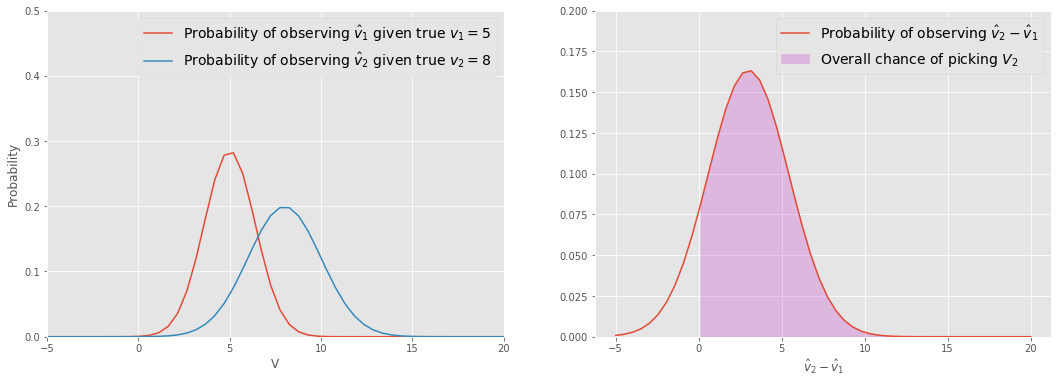

In [5]:
def plot_pdfs(true_v1=5, true_v2=8, 
              sigma_v1=1.4, sigma_v2=2):
    plt.xlim(-5, 20)
    plt.ylim(0, .5)
    xs = np.linspace(-5, 20)
    plt.plot(xs,gaussian(xs, mu=true_v1, sigma=sigma_v1))
    plt.plot(xs,gaussian(xs, mu=true_v2, sigma=sigma_v2))
    plt.xlabel('V')
    plt.ylabel('Probability')
    plt.legend(["Probability of observing $\hat{v}_1$ given true $v_1 = $" + str(true_v1),
                "Probability of observing $\hat{v}_2$ given true $v_2 = $" + str(true_v2)],
                fontsize=14)


def plot_pdfs_and_different(true_v1=5, true_v2=8, 
                            sigma_v1=1.4, sigma_v2=2):
    plt.figure(figsize=(18, 6))    
    plt.subplot(1, 2, 1)
    plot_pdfs(true_v1, true_v2, sigma_v1, sigma_v2)
    
    plt.subplot(1, 2, 2)
    standard_dev_of_difference = np.sqrt(sigma_v1 ** 2 + sigma_v2 ** 2)

    xs = np.linspace(-5, 20)
    difference = gaussian(xs, mu=true_v2 - true_v1, sigma=standard_dev_of_difference)
    plt.plot(xs, difference)

    plt.fill_between(xs[np.where(xs>0)], difference[np.where(xs>0)], 0, color='m',alpha=.2)
    plt.xlabel('$\hat{v}_2 - \hat{v}_1$')
    plt.ylim([0, 0.2])
    plt.legend(['Probability of observing $\hat{v}_2 - \hat{v}_1$',
                'Overall chance of picking $V_2$'], fontsize=14)
    plt.show()
    
plot_pdfs_and_different();

The area under the curve can be computed by solving the integral of the Gaussian distribution. This gives the chance that an observer will correctly pick $\hat{v}_2$ as faster. This is computed numerically in the cells below.

In [6]:
# TODO: Jesse; add function to compute purple shaded area, show example

We would like to compute this probability (that the observer answers $v_2$) for various true values of $v_1$ and $v_2$. The further apart the true values, or the lower the noise in the estimates, the less likely it is that we'll give the wrong answer. 

Let's see how the integral varies with different true values. Think about:
- what happens if the two true values are identical? Does this behaviour depend on variances?
- what happens if you keep the true values fixed (but not identical) and vary the variances?
- what happens if you keep the variances fixed but vary the true values?
- what happens when the variances are very small?

In [7]:
interact(plot_pdfs_and_different, 
         true_v1=(0,10,0.55), 
         true_v2=(0,10, 0.25), 
         sigma_v1=(.2,4), 
         sigma_v2=(.2,4));


interactive(children=(FloatSlider(value=5.0, description='true_v1', max=10.0, step=0.55), FloatSlider(value=8.0, description='true_v2', max=10.0, step=0.25), FloatSlider(value=1.4, description='sigma_v1', max=4.0, min=0.2), FloatSlider(value=2.0, description='sigma_v2', max=4.0, min=0.2), Output()), _dom_classes=('widget-interact',))

## The psychometric function
A psychometric function tells us how often subjects choose $\hat{v}_2$ depending on the difference between the two true values $v_1$ and $v_2$. You should have observed above that for fixed variances, varying the difference between the true values only affects the "difference gaussian" by shifting it along the x axis. This means that for every difference $(v_2 - v_1)$, we need to integrate the same gaussian between different limits. This gives us a "cumulative distribution function" for a Gaussian, which has a known form. 



In [8]:
def gaussian_integral(xs, mu, sigma):
    # This function computes the numerical integral of a Gaussian distribution with 
    # mean mu and standard deviation sigma
    binsize = np.diff(xs)[0]
    integral = [sum(gaussian(xs[0:i], mu, sigma) * binsize) for i, x in enumerate(xs)]
    # returns CDF
    return np.array(integral)
    
def plot_psychometric(sigma_diff):
    plt.title('The psychometric function')
    # CDF of zero-centred difference gaussian
    xs = np.linspace(-10, 10)
    plt.plot(xs, gaussian_integral(xs, 0, sigma_diff))
    plt.xlabel('True $v_2 - v_1$')
    plt.ylabel('Chance of picking $v_2$ as faster')

def plot_pdfs_diff_and_psychometric(true_v1=5, true_v2=8):
    sigma_v1 = 2
    sigma_v2 = 3
    plot_pdfs_and_different(true_v1, true_v2, sigma_v1, sigma_v2)
        
    plt.figure()
    sigma_diff = np.sqrt(sigma_v1 ** 2 + sigma_v2 ** 2)        
    plot_psychometric(sigma_diff)
    plt.show()
    
    #TODO: Jesse: add dot showing current sample on psychometric
    #TODO: Jesse: add label showing area of purple as value

In [9]:
interact(plot_pdfs_diff_and_psychometric, 
         true_v1=(0,10,0.5), 
         true_v2=(0,10, 0.5));

interactive(children=(FloatSlider(value=5.0, description='true_v1', max=10.0, step=0.5), FloatSlider(value=8.0, description='true_v2', max=10.0, step=0.5), Output()), _dom_classes=('widget-interact',))

Now let's see how our psychometric curve depends on the variance of the two estimators...

TODO: talk about this being experimentally variable, or a "true" parameter of the environment

In [10]:
def plot_pdfs_psychometric(sigma_v1, sigma_v2):
    
    true_v1 = 5
    true_v2 = 8
    plt.figure(figsize=(18, 6))    
    plt.subplot(1,2,1)
    plot_pdfs(true_v1, true_v2, 
              sigma_v1, sigma_v2)
    plt.title("Example observation PDFs for one set of true $(v_1, v_2)$")
    
    plt.subplot(1,2,2)
    sigma_diff = np.sqrt(sigma_v1 ** 2 + sigma_v2 ** 2)            
    plot_psychometric(sigma_diff)
    plt.show()
    
# FIXME: title make clear this is for one specific set of means

interact(plot_pdfs_psychometric, 
         sigma_v1=(.2,4), 
         sigma_v2=(.2,4));

interactive(children=(FloatSlider(value=2.1, description='sigma_v1', max=4.0, min=0.2), FloatSlider(value=2.1, description='sigma_v2', max=4.0, min=0.2), Output()), _dom_classes=('widget-interact',))